In [62]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
from lightning import LightningModule, Trainer
import torch
from torch import nn
from torch.nn import functional as F
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import seaborn as sns
import pandas as pd

In [59]:
class MLP(LightningModule):
    def __init__(self, in_features: int, num_classes: int, activation: nn.Module) -> None:
        super().__init__()
        self.in_features = in_features
        self.num_classes = num_classes
        self.activation = activation

        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(p=0.1),
            nn.Linear(in_features=self.in_features, out_features=500),
            activation(),
            nn.Dropout(p=0.2),
            nn.Linear(in_features=500, out_features=500),
            activation(),
            nn.Dropout(p=0.2),
            nn.Linear(in_features=500, out_features=500),
            activation(),
            nn.Dropout(p=0.3),
            nn.Linear(in_features=500, out_features=self.num_classes),
        )

        self.criteria = nn.CrossEntropyLoss() if num_classes > 2 else nn.BCEWithLogitsLoss()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.layers(x)
    
    def configure_optimizers(self) -> torch.optim.Optimizer:
        optimizer = torch.optim.Adadelta(self.parameters())
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', factor=0.5, patience=200, min_lr=0.1
        )
        return {
            'optimizer': optimizer,
            'lr_scheduler': scheduler,
            'monitor': 'train_loss'
        }

    def training_step(self, batch, batch_idx: int) -> torch.Tensor:
        x, y = batch
        preds = self(x)

        if self.num_classes == 2:
            preds = preds.squeeze(dim=-1)
            y_pred = F.sigmoid(preds).round()

            y_pred = y_pred.cpu().detach().numpy()
            y_true = y.cpu().detach().numpy()
        else:
            y_pred = torch.argmax(preds, dim=1).cpu().detach().numpy()
            y_true = y.cpu().detach().numpy()

        loss = self.criteria(preds, y.float().to(self.device) if self.num_classes == 2 else y)

        self.log('train_loss', loss, prog_bar=True, on_epoch=True, on_step=False)            

        acc = accuracy_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred, average='macro')
        precision = precision_score(y_true, y_pred, average='macro')
        recall = recall_score(y_true, y_pred, average='macro')

        self.log('train_acc', acc, prog_bar=True, on_epoch=True, on_step=False)
        self.log('train_f1', f1, on_epoch=True, on_step=False)
        self.log('train_precision', precision, on_epoch=True, on_step=False)
        self.log('train_recall', recall, on_epoch=True, on_step=False)

        return loss
    
    def test_step(self, batch, batch_idx: int) -> None:
        return super().test_step()


In [60]:
from utils import load_data, to_torch_dataset, to_torch_loader

X_train, y_train, X_test, y_test = load_data(name='Beef', task='classification', split='full')
train_set, test_set = to_torch_dataset(X_train, y_train, X_test, y_test)
train_loader, test_loader = to_torch_loader(train_dataset=train_set, test_dataset=test_set)

In [61]:
trainer = Trainer(
    max_epochs=1000,
    accelerator='gpu',
)

num_classes = len(np.unique(y_train))
model_relu = MLP(in_features=X_train.shape[-1], num_classes=num_classes, activation=nn.ReLU)

trainer.fit(model_relu, train_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type             | Params
----------------------------------------------
0 | layers   | Sequential       | 739 K 
1 | criteria | CrossEntropyLoss | 0     
----------------------------------------------
739 K     Trainable params
0         Non-trainable params
739 K     Total params
2.956     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1000` reached.


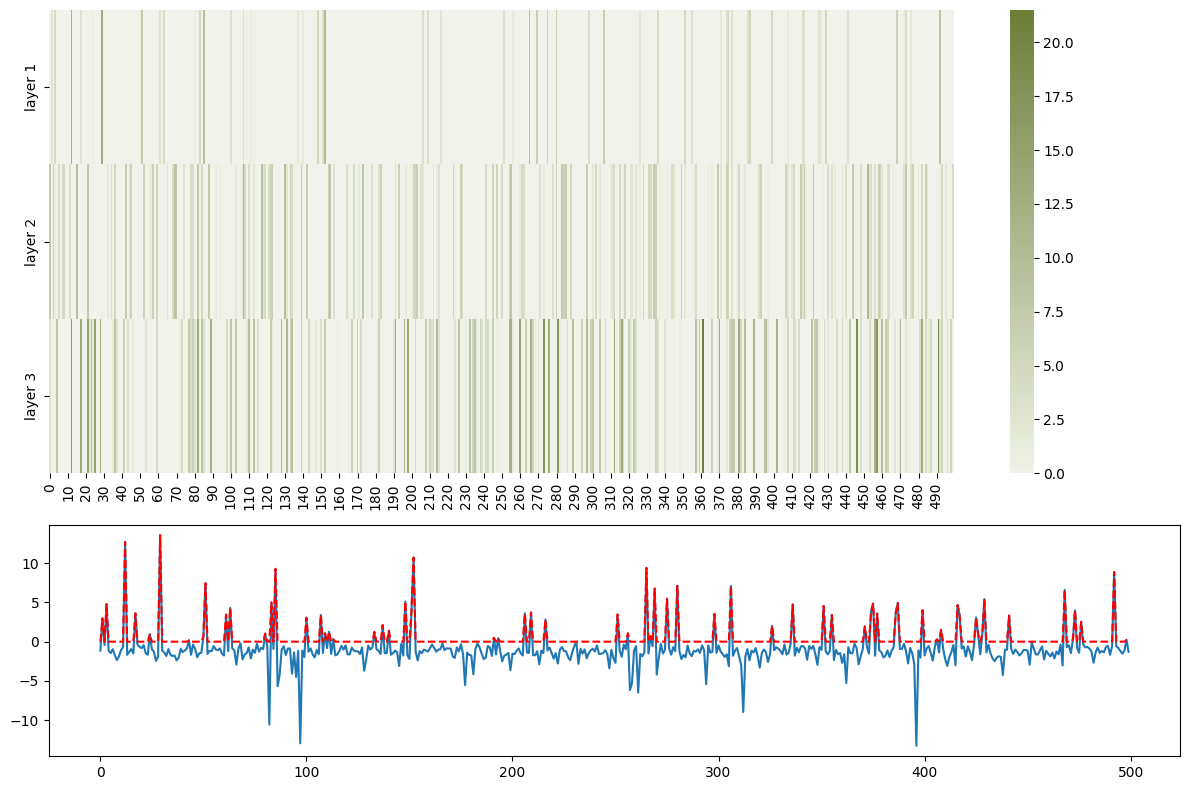

In [90]:
fig, (ax0, ax1) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [2, 1]}, figsize=(12, 8))

sample = train_set[:1][0] # 1, 1, 470

flat_sample = model_relu.layers[0](sample) # 1, 470

act1 = model_relu.layers[3](model_relu.layers[2](model_relu.layers[1](flat_sample)))
act2 = model_relu.layers[6](model_relu.layers[5](model_relu.layers[4](act1)))
act3 = model_relu.layers[9](model_relu.layers[8](model_relu.layers[7](act2)))

activations_ = torch.cat([act1, act2, act3], dim=0).detach().cpu().numpy()
activations_ = pd.DataFrame(data=activations_, index=['layer 1', 'layer 2', 'layer 3'])

cmap = sns.diverging_palette(100, 100, as_cmap=True)

sns.heatmap(activations_, cmap=cmap, center=0, ax=ax0, cbar_kws={})

l1_ = model_relu.layers[2](model_relu.layers[1](flat_sample))
act1_ = model_relu.layers[3](l1_).detach().cpu().numpy()

ax1.plot(list(range(0, l1_.shape[-1])), l1_.detach().cpu().numpy()[0])
ax1.plot(list(range(0, l1_.shape[-1])), act1_[0], color='red', linestyle='dashed')

plt.tight_layout()

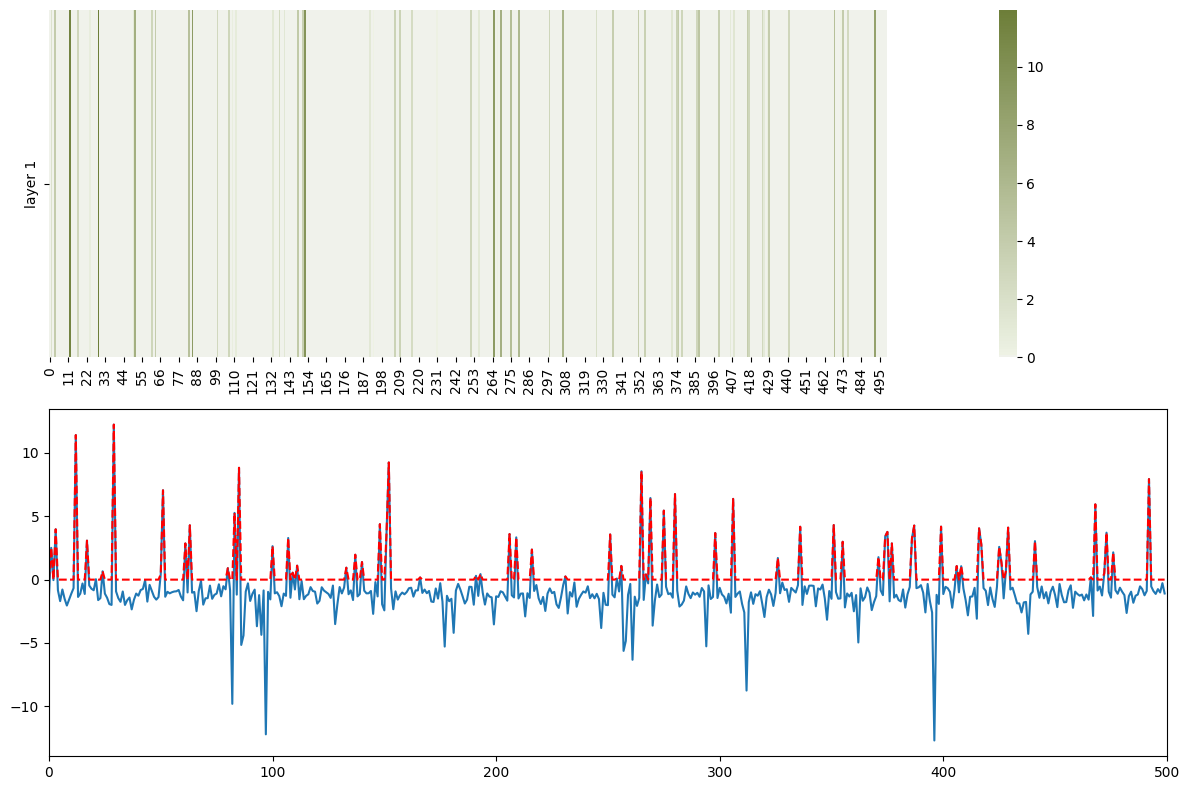

In [99]:
fig, (ax0, ax1) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [1, 1]}, figsize=(12, 8))

sample = train_set[:1][0] # 1, 1, 470

flat_sample = model_relu.layers[0](sample) # 1, 470

act1 = model_relu.layers[3](model_relu.layers[2](model_relu.layers[1](flat_sample)))
act2 = model_relu.layers[6](model_relu.layers[5](model_relu.layers[4](act1)))
act3 = model_relu.layers[9](model_relu.layers[8](model_relu.layers[7](act2)))

activations_ = torch.cat([act1], dim=0).detach().cpu().numpy()
activations_ = pd.DataFrame(data=activations_, index=['layer 1'])

cmap = sns.diverging_palette(100, 100, as_cmap=True)

sns.heatmap(activations_, cmap=cmap, center=0, ax=ax0, cbar_kws={'pad': 0.1})

l1_ = model_relu.layers[2](model_relu.layers[1](flat_sample))
act1_ = model_relu.layers[3](l1_).detach().cpu().numpy()

ax1.plot(list(range(0, l1_.shape[-1])), l1_.detach().cpu().numpy()[0])
ax1.plot(list(range(0, l1_.shape[-1])), act1_[0], color='red', linestyle='dashed')
ax1.set_xlim(0, act1_.shape[-1])

plt.tight_layout()

In [67]:
class LeakySineLU(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        
    def forward(self, x):
        return torch.max(torch.sin(x) ** 2 + x, 0.5 * (torch.sin(x) ** 2 + x))

trainer = Trainer(
    max_epochs=1000,
    accelerator='gpu',
)

num_classes = len(np.unique(y_train))
model_lsinelu = MLP(in_features=X_train.shape[-1], num_classes=num_classes, activation=LeakySineLU)

trainer.fit(model_lsinelu, train_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type             | Params
----------------------------------------------
0 | layers   | Sequential       | 739 K 
1 | criteria | CrossEntropyLoss | 0     
----------------------------------------------
739 K     Trainable params
0         Non-trainable params
739 K     Total params
2.956     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1000` reached.


<Axes: >

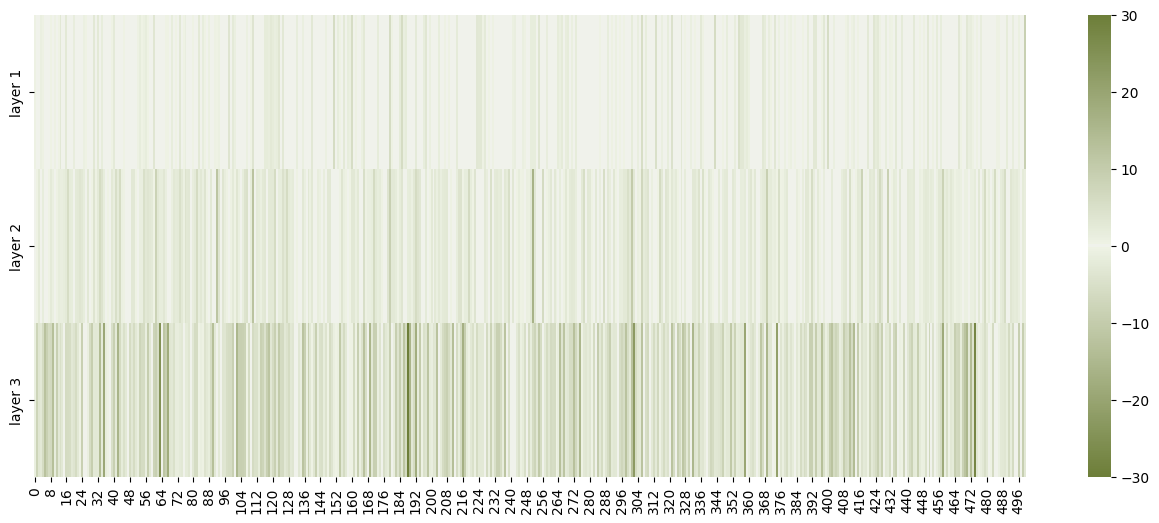

In [91]:
sample = train_set[:1][0] # 1, 1, 470

flat_sample = model_lsinelu.layers[0](sample) # 1, 470

act1 = model_lsinelu.layers[3](model_lsinelu.layers[2](model_lsinelu.layers[1](flat_sample)))
act2 = model_lsinelu.layers[6](model_lsinelu.layers[5](model_lsinelu.layers[4](act1)))
act3 = model_lsinelu.layers[9](model_lsinelu.layers[8](model_lsinelu.layers[7](act2)))

activations_ = torch.cat([act1, act2, act3], dim=0).detach().cpu().numpy()
activations_ = pd.DataFrame(data=activations_, index=['layer 1', 'layer 2', 'layer 3'])

cmap = sns.diverging_palette(100, 100, as_cmap=True)

plt.figure(figsize=(16, 6))
sns.heatmap(activations_, cmap=cmap, vmin=-30, vmax=30)